Project name: Pneumonia detection using X-ray images

Group: BDA-2102 

Students: Zhauymbayeva Madina, Serikkazy Ulpan 

In [1]:
import tensorflow as tf
print(tf.__version__)

2.11.0


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os, glob, random, pathlib, warnings, itertools, math
from keras.utils.vis_utils import plot_model
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score

## Installing Kaggle and uploading dataset into colab files




In [3]:
# install Kaggle
!pip install -q kaggle

In [4]:
# upload kaggle json file (Kaggle's beta API)
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"madinaz","key":"32dfbb8b1c6b623bf0c90ef5b3d23e66"}'}

In [5]:
# create kaggle folder
! mkdir ~/.kaggle

In [6]:
# copy the kaggle.json to folder created
! cp kaggle.json ~/.kaggle/

In [7]:
# permission for the json to act
! chmod 600 ~/.kaggle/kaggle.json

In [8]:
# to list all datasets in kaggle
! kaggle datasets list

ref                                                        title                                       size  lastUpdated          downloadCount  voteCount  usabilityRating  
---------------------------------------------------------  -----------------------------------------  -----  -------------------  -------------  ---------  ---------------  
themrityunjaypathak/covid-cases-and-deaths-worldwide       Covid Cases and Deaths WorldWide             8KB  2023-02-01 12:22:51           3496         91  1.0              
datascientistanna/customers-dataset                        Shop Customer Data                          23KB  2023-02-07 18:42:21           2515         70  1.0              
rajugc/imdb-top-250-movies-dataset                         IMDB Top 250 Movies Dataset                 52KB  2023-02-11 16:02:01            937         38  1.0              
ahsan81/hotel-reservations-classification-dataset          Hotel Reservations Dataset                 480KB  2023-01-04 12:50:31  

In [9]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [00:20<00:00, 154MB/s]
100% 2.29G/2.29G [00:20<00:00, 122MB/s]


In [10]:
!unzip chest-xray-pneumonia.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jp

## Loading the dataset

After the kaggle dataset is loaded into Colab files, we get path for train, validation and test sets.

In [11]:
# train, validation and test directories
train_path = "/content/chest_xray/train"
val_path = "/content/chest_xray/val"
test_path = "/content/chest_xray/test"

In [12]:
# We are defining the image size as 150 and batch size as 32
IMG_SIZE = 150
BATCH_SIZE = 32

## Getting to know the dataset

In [13]:
# number of images in each set
def images_number(dir):
    for path in pathlib.Path(dir).iterdir():
        if path.is_dir():
            print(str(len([name for name in os.listdir(path) \
            if os.path.isfile(os.path.join(path, name))])) + " x-ray images in " + \
            str(path.name))
print('Train:')
images_number(os.path.join(train_path))
print('\nTest:')
images_number(os.path.join(test_path))
print('\nValidation:')
images_number(os.path.join(val_path))

Train:
3875 x-ray images in PNEUMONIA
1341 x-ray images in NORMAL

Test:
390 x-ray images in PNEUMONIA
234 x-ray images in NORMAL

Validation:
8 x-ray images in PNEUMONIA
8 x-ray images in NORMAL


Validation data set has only 16 images. For that reason, we will append the validation images to train set and we will split the train set into training and validation (90% - training, 10% - validation) in the ImageDataGenerator.

In [14]:
# normal and pneumonia directories
train_normal = os.path.join(train_path, 'NORMAL') 
train_pneumonia = os.path.join(train_path, 'PNEUMONIA')
val_normal= os.path.join(val_path, 'NORMAL')
val_pneumonia = os.path.join(val_path, 'PNEUMONIA')
test_normal = os.path.join(test_path, 'NORMAL')
test_pneumonia = os.path.join(test_path, 'PNEUMONIA')

Here, validation set images are moved to the training set.

In [15]:
all_normal = os.listdir(val_normal)
for f in all_normal:
    src_path = os.path.join(val_normal, f)
    dst_path = os.path.join(train_normal, f)
    os.rename(src_path, dst_path)

all_pneu = os.listdir(val_pneumonia)
for f in all_pneu:
    src_path = os.path.join(val_pneumonia, f)
    dst_path = os.path.join(train_pneumonia, f)
    os.rename(src_path, dst_path)

In [16]:
# number of images in each set
count_train_normal = len(os.listdir(train_normal))
count_train_pneumonia = len(os.listdir(train_pneumonia))
total = count_train_normal + count_train_pneumonia
print('Normal x-ray images in the training set:', count_train_normal)
print('Pneumonia x-ray images in the training set:', count_train_pneumonia)
print('Total:', total)

Normal x-ray images in the training set: 1349
Pneumonia x-ray images in the training set: 3883
Total: 5232


Bar graph below proves that the number of normal x ray images in the *training set* is less, or the data in the that set is unbalanced. For that reason, we will use assign class weights to make data balanced and we will split the training set into train and validation (90% - training, 10% - validation). Also, data augmentation will be used for better accuracy and to avoid overfitting.

In [17]:
# bar plot to show the proportion of normal x images with pneumonia x ray images in the set
def bar_plot(dir_normal, dir_pneumonia):
  normal_len = len(os.listdir(dir_normal))
  pneu_len = len(os.listdir(dir_pneumonia))
  fig, ax  = plt.subplots(figsize=(7, 5))
  ax.bar([1, 2.5], [normal_len, pneu_len], width=1,
  tick_label=['Normal', 'Pneumonia'], align='center', color = ['tab:blue', 'tab:orange'])

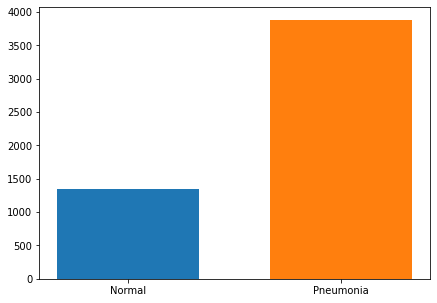

In [18]:
bar_plot(train_normal, train_pneumonia)

Class 0 (Normal) weight is greater than class 1 weight (Pneumonia), meaning that the number of the normal x-ray images is less. To make the training data balanced, each normal image will be weighted more to balance the data.

In [19]:
bias = np.log([count_train_pneumonia/count_train_normal])
bias

array([1.05724447])

In [20]:
weight_0 = (1 / count_train_normal) * (total) / 2.0 
weight_1 = (1 / count_train_pneumonia) * (total) / 2.0
class_weight = {0: weight_0, 1: weight_1}

print('Weight for class 0 Normal: {:.2f}'.format(weight_0))
print('Weight for class 1 Pneumonia: {:.2f}'.format(weight_1))

Weight for class 0 Normal: 1.94
Weight for class 1 Pneumonia: 0.67


The code below prints the train set images. Normal x rays have less white shading in the lung area and more clear, while Pneumonia x rays are more opaque.

Found 5232 files belonging to 2 classes.


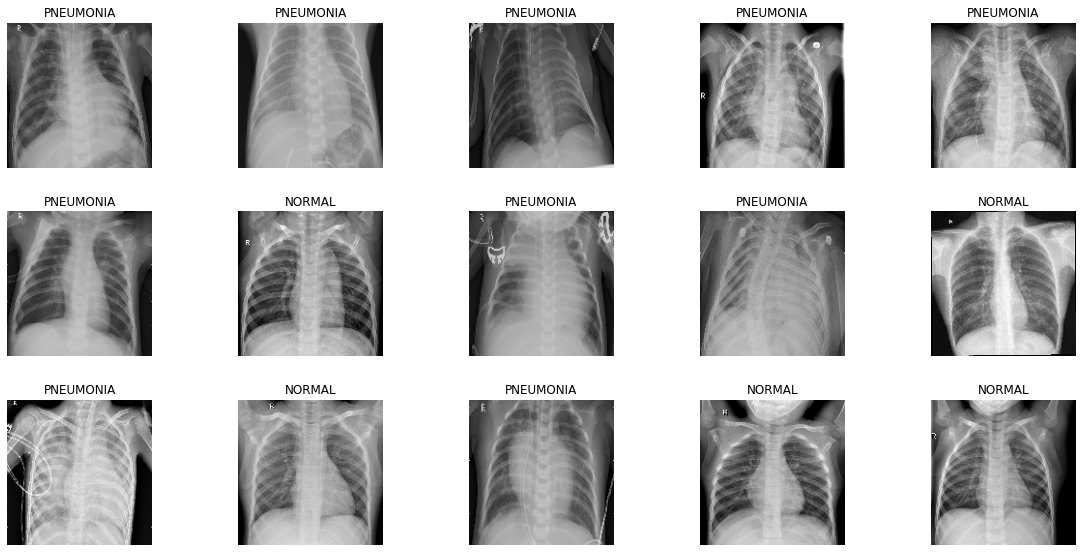

In [23]:
train_set = tf.keras.utils.image_dataset_from_directory(train_path, image_size=(IMG_SIZE, IMG_SIZE))
classes = train_set.class_names
plt.figure(figsize=(20, 20))
for images, labels in train_set.take(1):
  for i in range(15):
    ax = plt.subplot(6, 5, i + 1)
    plt.subplots_adjust(hspace=0.3)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(classes[labels[i]])
    plt.axis("off")

## Data preprocessing
keras.preprocessing.image class ImageDataGenerator generates batches of tensor image data with real-time data augmentation. Parameters such as rescale, rotation_range, shear_range, zoom_range and horizontal_flip are used for augmentation on training set. Validation split is set to 0.1, so
Training data (90%) and Validation data (10%) will be created from the data of train set. flow_from_directory reads the images from folders.

In [163]:
# create a data generator for training and validation
# all images will be rescaled by 1./255

datagen = ImageDataGenerator(rescale=1./255)

train_datagen = ImageDataGenerator(
      rescale=1./255,  # [0,1] 
      rotation_range = 30, # range for rotation
      shear_range = 0.2, # shear intensity                    
      zoom_range=0.2, # the image is enlarged 
      horizontal_flip=True, # randomly flips images horizontally
      validation_split=0.1  # fraction of images reserved for validation
    )

train_generator = train_datagen.flow_from_directory(
        train_path, # This is the target directory
        target_size=(IMG_SIZE, IMG_SIZE), # All images will be resized to 150x150
        batch_size= BATCH_SIZE, 
        class_mode="binary",
        subset='training'
        )
    
validation_generator = train_datagen.flow_from_directory(
        train_path,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size= BATCH_SIZE, 
        class_mode="binary",
        subset='validation'
        )

test_generator = datagen.flow_from_directory(
        test_path,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size= BATCH_SIZE,
        class_mode="binary",
        shuffle=False
        )

Found 4710 images belonging to 2 classes.
Found 522 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


RGB images with a batches of 150x150 and shape (32, 150, 150, 3). Binary labels with a shape (32,). 32 is the number of samples in each batch or the batch size. Labels are Normal and Pneumonia.  

In [26]:
# learn more about data batches
image, label= train_generator.next()
print(f'Image batch shape: {image.shape}')
print(f'Label batch shape: {label.shape}')
labels = sorted(train_generator.class_indices.items(), key = lambda pair:pair[1])
labels = np.array([key.title() for key, value in labels])
print(labels)

Image batch shape: (32, 150, 150, 3)
Label batch shape: (32,)
['Normal' 'Pneumonia']


## Model Building

Code below will visualize the accuracy and loss plots of training and validation.

In [27]:
def plot_graph(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  
  epochs = range(len(acc))
  plt.figure(figsize=(15, 5)) 
  plt.subplot(1, 2, 1)
  plt.title('Training and validation accuracy')
  plt.plot(epochs, acc, color='blue', label='Train')
  plt.plot(epochs, val_acc, color='orange', label='Val')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.grid()

  plt.subplot(1, 2, 2)
  plt.title('Training and validation loss')
  plt.plot(epochs, loss, color='blue', label='Train')
  plt.plot(epochs, val_loss, color='orange', label='Val')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.grid()
  
  plt.show()

The model is built with 4 convolutional blocks consisting of convolutional layers, max-pooling. The depth of the feature maps increased from 32 to 64 and size of the feature maps decreased from 150x150 to 10x10. In the end, we used the Dense layer of size 3 and sigmoid function as this is a binary classification problem. For compilation, Adam is the optimizer and binary cross-entropy is the loss. In between, Dropout is used to avoid overfitting. As this is the imbalanced data set, for the metric, Precision and Recall are included and they show a more accurate view of how effective the model is.

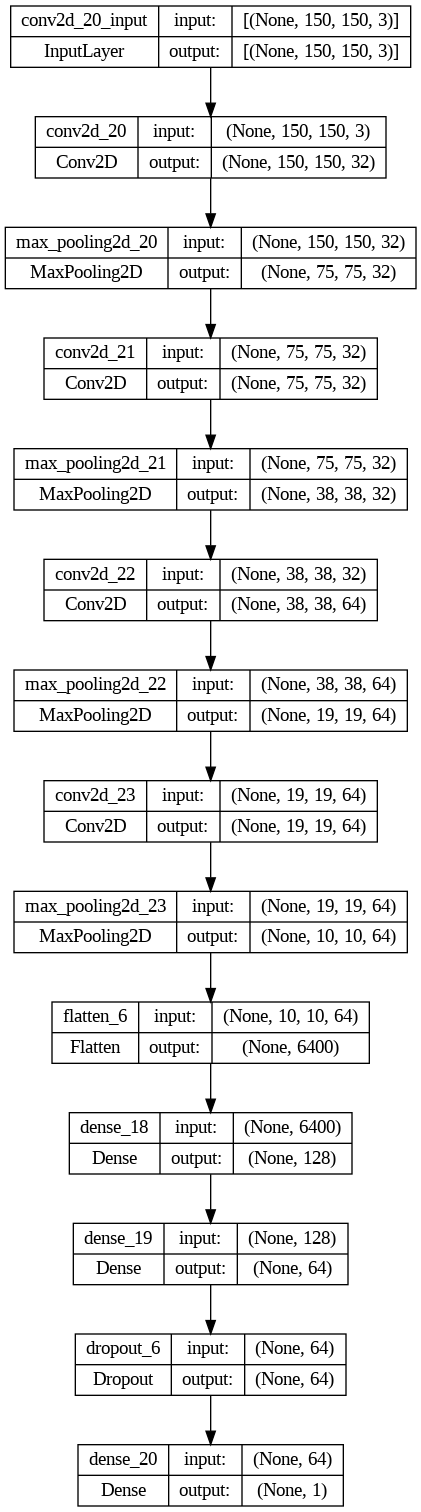

In [111]:
model = Sequential()

model.add(Conv2D(32 , (3,3) , padding = 'same' , activation = 'relu' , input_shape = (IMG_SIZE,IMG_SIZE,3)))
model.add(MaxPool2D((2,2) , padding = 'same'))

model.add(Conv2D(32 , (3,3) , padding = 'same' , activation = 'relu'))
model.add(MaxPool2D((2,2) , padding = 'same'))

model.add(Conv2D(64 , (3,3) , padding = 'same' , activation = 'relu'))
model.add(MaxPool2D((2,2) , padding = 'same'))

model.add(Conv2D(64 , (3,3) , padding = 'same' , activation = 'relu'))
model.add(MaxPool2D((2,2) , padding = 'same'))

model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dense(units = 64, activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(units = 1 , activation = 'sigmoid'))


metrics = [
  'accuracy', 
  tf.keras.metrics.Precision(name='precision'),
  tf.keras.metrics.Recall(name='recall'),
]

model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics= metrics)

tf.keras.utils.plot_model(model, show_shapes=True)


In [112]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 150, 150, 32)      896       
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 75, 75, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 75, 75, 32)        9248      
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 38, 38, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 38, 38, 64)        18496     
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 19, 19, 64)      

Early Stopping  callback is used to avoid overfitting by stopping the epochs depending on a metric and conditions. restore_best_weights is set to true, so the returned model will be the model with the best weights. Reduce learning rate when a metric has stopped improving.

In [113]:
early = EarlyStopping(patience=10, restore_best_weights=True)
reduction = ReduceLROnPlateau(patience = 2, verbose = 1, factor = 0.3, min_lr = 0.000001)

In [114]:
steps_per_epoch = len(train_generator.labels) // BATCH_SIZE
validation_step = len(validation_generator.labels) // BATCH_SIZE

history = model.fit(train_generator, validation_data = validation_generator,
                    epochs = 10, class_weight=class_weight,
                    callbacks = [early, reduction])

Epoch 1/10
148/148 [==============================] - 74s 475ms/step - loss: 0.5328 - accuracy: 0.6601 - precision: 0.9107 - recall: 0.6009 - val_loss: 0.4128 - val_accuracy: 0.8333 - val_precision: 0.9013 - val_recall: 0.8711 - lr: 0.0010
Epoch 2/10
148/148 [==============================] - 71s 481ms/step - loss: 0.3010 - accuracy: 0.8688 - precision: 0.9612 - recall: 0.8578 - val_loss: 0.3799 - val_accuracy: 0.8525 - val_precision: 0.9814 - val_recall: 0.8170 - lr: 0.0010
Epoch 3/10
148/148 [==============================] - 74s 499ms/step - loss: 0.2430 - accuracy: 0.9028 - precision: 0.9700 - recall: 0.8967 - val_loss: 0.2862 - val_accuracy: 0.9061 - val_precision: 0.9403 - val_recall: 0.9330 - lr: 0.0010
Epoch 4/10
148/148 [==============================] - 74s 499ms/step - loss: 0.2282 - accuracy: 0.9040 - precision: 0.9695 - recall: 0.8990 - val_loss: 0.2673 - val_accuracy: 0.8985 - val_precision: 0.9718 - val_recall: 0.8892 - lr: 0.0010
Epoch 5/10
148/148 [====================

The reduction in loss and validation loss with epochs indicates that the model is converging. In 10 epochs, it can achieve 94% of training and 91% validation accuracy.

Graph depicts that the training accuracy is increasing, while its loss is decreasing.

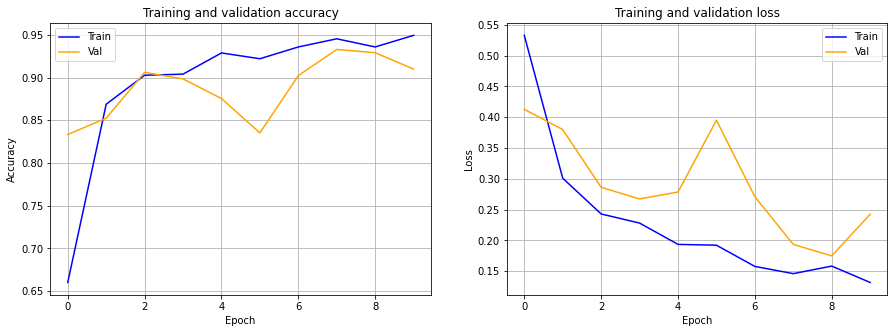

In [115]:
plot_graph(history)

## Model Evaluation

We got test accuracy of 92.15%, test loss of 0.22, test precision of 93.38%, test recall of 94.10%.

In [116]:
print("Evaluation:")
evaluation_test = model.evaluate(test_generator, steps=len(test_generator))
print("%s%.2f  "% ("Test Loss     : ", evaluation_test[0]))
print("%s%.2f%s"% ("Test Accuracy : ", evaluation_test[1]*100, "%"))
print("%s%.2f%s"% ("Test Precision : ", evaluation_test[2]*100, "%"))
print("%s%.2f%s"% ("Test Recall : ", evaluation_test[3]*100, "%"))

Evaluation:
20/20 [==============================] - 5s 252ms/step - loss: 0.2194 - accuracy: 0.9215 - precision: 0.9338 - recall: 0.9410
Test Loss     : 0.22  
Test Accuracy : 92.15%
Test Precision : 93.38%
Test Recall : 94.10%


Classification report details is shown below.
We obtained a recall of 94% for Pneumonia class and Precision of 93%, which are pretty good. 

In [117]:
actual = test_generator.classes
pred = model.predict(test_generator)
pred_probs = pred.copy()
pred[pred <= 0.5] = 0
pred[pred > 0.5] = 1
print(classification_report(actual, pred, target_names = ['Normal','Pneumonia']))

20/20 [==============================] - 8s 381ms/step
              precision    recall  f1-score   support

      Normal       0.90      0.89      0.89       234
   Pneumonia       0.93      0.94      0.94       390

    accuracy                           0.92       624
   macro avg       0.92      0.91      0.92       624
weighted avg       0.92      0.92      0.92       624



False Negatives for Model are just 23 and False Positives are 26. Our model able to classify 575 x ray images correctly out of 624 test images.

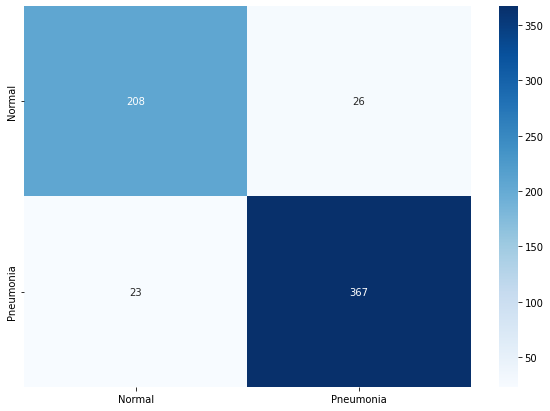

In [118]:
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix(actual, pred), annot=True,fmt='.4g', 
            xticklabels=['Normal','Pneumonia'], yticklabels=['Normal','Pneumonia'], cmap='Blues')
plt.show()

In [119]:
test_steps = len(test_generator.labels) // BATCH_SIZE
prediction = model.predict(test_generator, test_steps)

20/20 [==============================] - 6s 270ms/step


ROC Curve with AUC score (0.97) is shown below. 

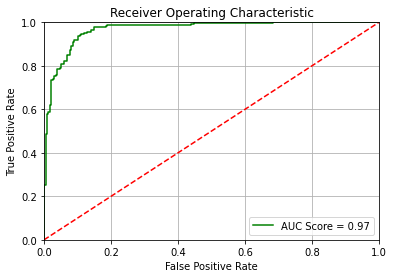

In [120]:
false_positive_rate, true_positive_rate, threshold = roc_curve(actual, prediction) 
auc = roc_auc_score(test_generator.classes, prediction) 
plt.title('Receiver Operating Characteristic')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.plot(false_positive_rate, true_positive_rate, 'g', label = 'AUC Score = %0.2f' % auc)
plt.plot([0, 1], [0, 1],'r--')
plt.legend()
plt.grid()
plt.show()

Some predictions on the test set are shown below. 1st image is from the normal class, model prediction is also normal. 2nd image is taken from pneumonia class, but model prediction is normal.

['Normal' 'Pneumonia']
1/1 [==============================] - 0s 37ms/step
Correct label: Normal
Predicted label: Normal


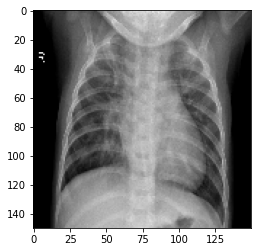

Correct label: Pneumonia
Predicted label: Normal


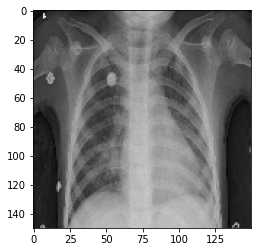

In [162]:
test_image_batch, test_label_batch = next(iter(test_generator))
true_label_ids = np.argmax(test_label_batch, axis=-1)

labels = sorted(test_generator.class_indices.items(), key=lambda pair:pair[1])
labels = np.array([key.title() for key, value in labels])
print(labels)

predicted_ids = np.argmax(pred, axis=-1)
predicted_labels = labels[predicted_ids]
true_labels = labels[true_label_ids]
pred = model.predict(test_image_batch)
labels = ['Normal', 'Pneumonia']

for i in range(2):
  print('Correct label:', labels[i].title())
  print('Predicted label:', predicted_labels[i].title())
  correct_image = test_image_batch[i]
  plt.imshow(correct_image)
  plt.show()

## Test the model predictions with local host using gradio

In [127]:
!pip install gradio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.2/14.2 MB 84.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.7/140.7 KB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 89.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.5/84.5 KB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.0/107.0 KB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 KB 9.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.2/56.2 KB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 KB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.1/52.1 KB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 KB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━

In [128]:
import gradio as gr

In [146]:
# predict if the x-ray images is in Normal class or Pneumonia class
def Prediction(image):
  image = np.array(image)/255
  image = image.reshape(-1, 150, 150, 3)
  isPneumonia = model.predict(image)[0]
  class_img  = "Normal" if isPneumonia < 0.5 else 'Pneumonia'
  return class_img

In [167]:
# input
image = gr.inputs.Image(shape=(150, 150))
label = gr.outputs.Label(num_top_classes=1)

/usr/local/lib/python3.8/dist-packages/gradio/inputs.py:257: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/gradio/deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)
/usr/local/lib/python3.8/dist-packages/gradio/outputs.py:197: UserWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/gradio/deprecation.py:40: UserWarning: The 'type' parameter has been deprecated. Use the Number component instead.
  warnings.warn(value)


In [148]:
pred = model.predict(test_generator)
for i in range(len(pred)):
  if pred[i]>0.5:
    pred[i]=1
  else:
    pred[i]=0

20/20 [==============================] - 5s 213ms/step


Model able to classify x-ray images in between 20 and 40 ms/step.

In [166]:
interface = gr.Interface(fn = Prediction, title = "Pneumonia Detection",
                             inputs = image, outputs = label,
                             interpretation = "default").launch(debug = True, share = True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://9a25540a-fd52-44d6.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces


1/1 [==============================] - 0s 23ms/step
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7861 <> https://9a25540a-fd52-44d6.gradio.live


This x-ray image was taken from normal class folder, model predicted it as *normal* image, which is *true*.

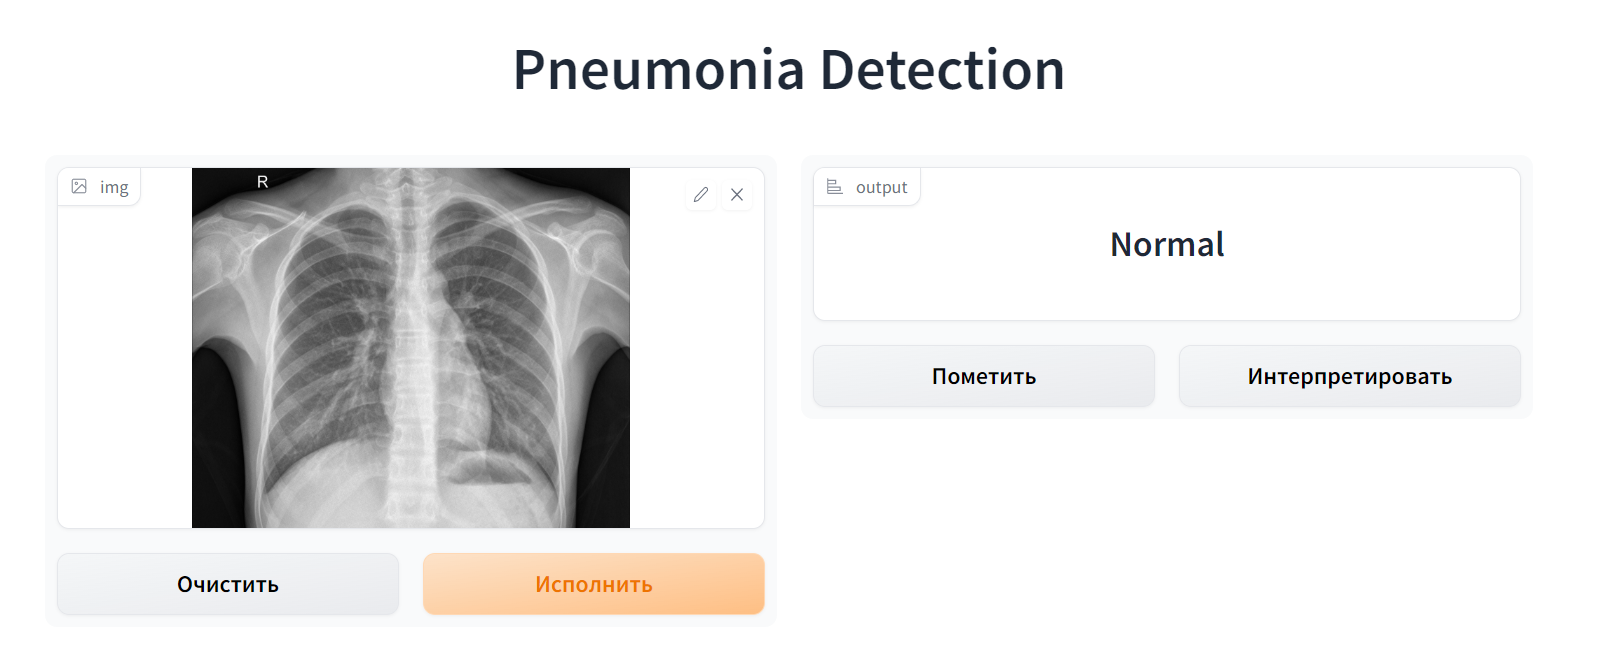

This x-ray image was taken from normal class folder, model predicted it as *pneumonia* image, which is *not true*.

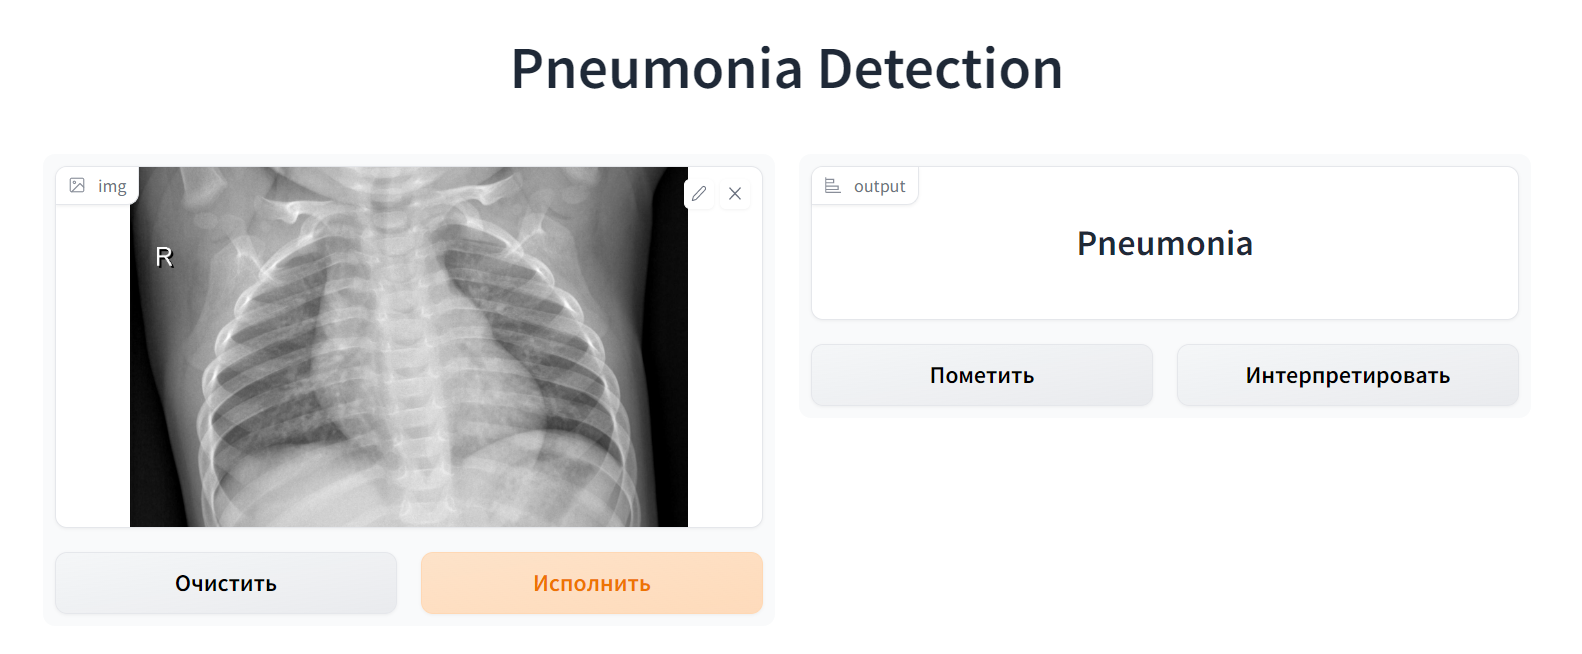

This x-ray image was taken from pneumonia class folder, model predicted it as *pneumonia* image, which is *true*.

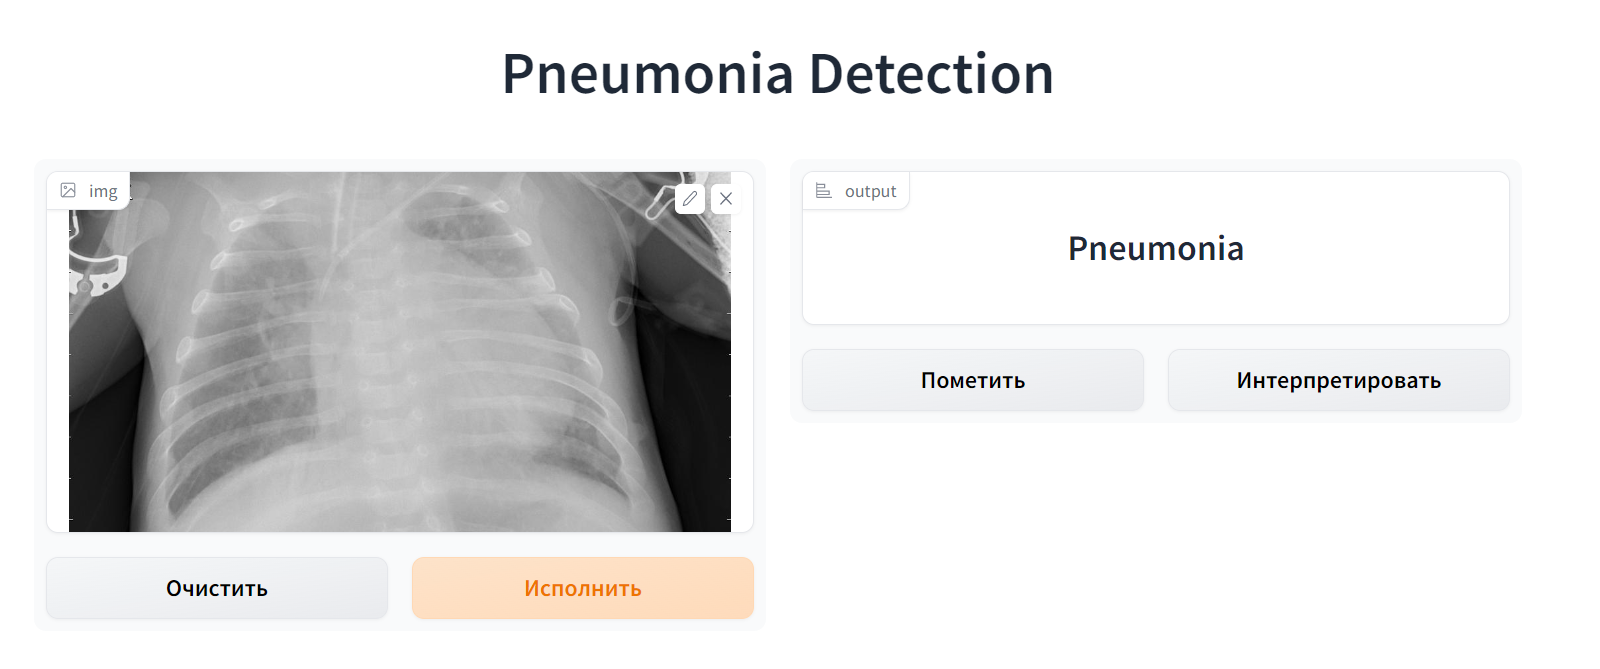

In [ ]:
# Save model
model.save("/content/my_model.h5")

In [ ]:
!ls -lha

total 2.4G
drwxr-xr-x 1 root root 4.0K Feb 16 14:50 .
drwxr-xr-x 1 root root 4.0K Feb 16 13:11 ..
drwxr-xr-x 7 root root 4.0K Feb 16 13:20 chest_xray
-rw-r--r-- 1 root root 2.3G Feb 16 13:20 chest-xray-pneumonia.zip
drwxr-xr-x 4 root root 4.0K Feb 14 14:36 .config
-rw-r--r-- 1 root root   63 Feb 16 13:17 kaggle.json
-rw-r--r-- 1 root root 102K Feb 16 13:29 model.png
-rw-r--r-- 1 root root  11M Feb 16 14:50 my_model.h5
-rw-r--r-- 1 root root  11M Feb 16 14:49 my_model.hdf5
drwxr-xr-x 1 root root 4.0K Feb 14 14:37 sample_data


In [ ]:
# Download saved model to local machine
from google.colab import files
files.download("/content/my_model.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>